In [1]:
%matplotlib inline
import pymc as pm
import matplotlib.pyplot as plt
import scipy.stats as st
import arviz as az

import numpy as np
import warnings
warnings.filterwarnings("ignore")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Wird später gebraucht
def hdi(a,b, prob = 0.95):
    k = 0
    x = np.linspace(0,1,100000)
    y = st.beta.pdf(x,a,b)
    while True:
       k = k+0.0001
       if np.sum(y[y > k])/np.size(x) < prob:
        break
    hdi_l, hdi_r = x[np.argwhere(y > k)][0][0] ,x[np.argwhere(y > k)][np.argwhere(y > k).size-1][0]
    return hdi_l, hdi_r

def plot_beta(a,b):
    x = np.linspace(0,1,1000) 
    y = st.beta.pdf(x,a,b)
    hdi_l, hdi_r = hdi(a,b)
    omega = (a-1)/(a+b-2)
    plt.plot(x,y)

    plt.plot([hdi_l, hdi_r],[.1,.1])
    plt.text((hdi_l+hdi_r)/2, .5, "95  HDI", ha="center")
    plt.text(hdi_l, .2, str(np.round(hdi_l,3)), ha="right")
    plt.text(hdi_r,.2, str(np.round(hdi_r,3)), ha="left")

    plt.text(0.2, st.beta.pdf(omega,a,b)-.5, "om="+str(np.round(omega,3)), ha="right")

In [3]:
trials = 20
head = 4 

# unknown value in a real experiment

data = np.zeros(trials)
data[np.arange(head)]  = 1

Es wird ein Datenvektor erzeugt, der mit `pymc` kompatibel ist. 

In [4]:
alph = 1
bet = 1

with pm.Model() as our_first_model:
   theta = pm.Beta('theta', alpha=alph, beta=bet)
   y = pm.Bernoulli('y', p=theta, observed=data)
   trace = pm.sample(100)
   

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 2 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


- Die Formparameter der Beta-Verteilung als Prior-Verteilung werden definiert: $a=1$, $b=1$

- Mit `with pm.Model() as our_first_model:` wird `pymc` angewiesen, ein Modell zu erstellen. 

- `our_first_model` ist einfach der Name des Modells. Das hat den Vorteil, dass wir später weitere Komponenten zu unserem Modell hinzufügen können. Zum Beispiel:

- `theta = pm.Beta(theta, alpha=alph, beta=bet)` definiert die Prior-Verteilung mit bereits angegebenen Parametern `alph` und `bet`.

- `y = pm.Bernoulli(y, p=theta, observed=data)`  legt die Bernoulli-Likelihood-Funktion mit Wkeiten `p=theta` - die Beta-verteilt sind - und mit Daten `observed=data` fest 

- `trace = pm.sample()` führt den MCMC-Algorithmus durch. Alle Resultate werden in einen sogenannten _Container_ `trace` gespeichert, auf den dann `arviz` zurückgreifen kann.

- Mit Option `draws=10000` kann angegeben werden, wieviele Samples erzeugt werden und mit der Option `tune=1000`, wieviele Samples am Anfang ignoriert werden

Mit `pm.plot_trace(trace)` werden die Posterior-Verteilungen für die vier `chains` dargestellt.

array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

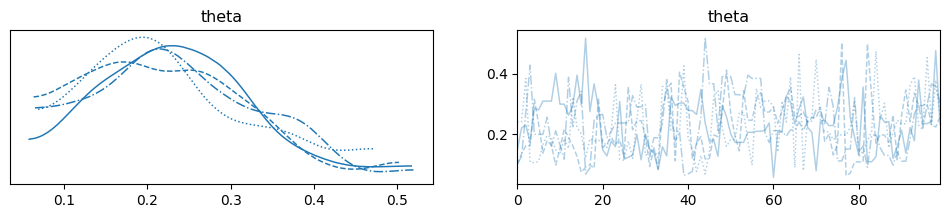

In [5]:
az.plot_trace(trace)

Auf der linken Seite sehen wir die Posterior-Verteilungen.  Auf der rechten Seite ein Zeitreihenplot, woraus ersichtlich ist, dass die Verteilungen um $ \theta=0.2 $ effizient abgetastet wird. 

In [6]:
az.summary(trace, hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.229,0.093,0.064,0.391,0.007,0.005,167.0,233.0,1.02


Die Posterior-Verteilung kann aufgezeichnet werden mit: 
`az.plot_posterior(trace, point_estimate='mode', hdi_prob=0.95)`. Mit der Option `point_estimate` wird angegeben, ob der Mittelwert (`mean`) oder der Modus (`mode`) angegeben wird. Das HDI ist ebenfalls eingezeichnet und mit den Intervallgrenzen versehen. 


<Axes: title={'center': 'theta'}>

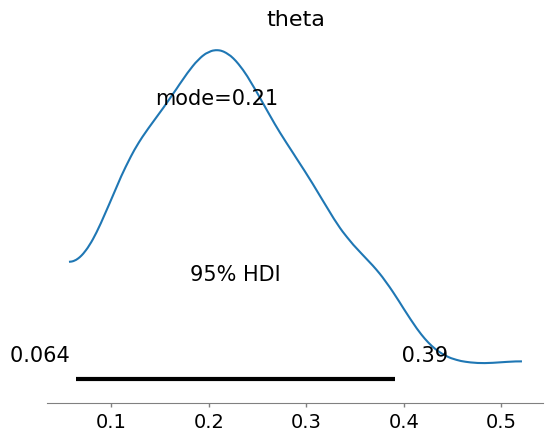

In [7]:
az.plot_posterior(trace, hdi_prob=.95, point_estimate="mode")

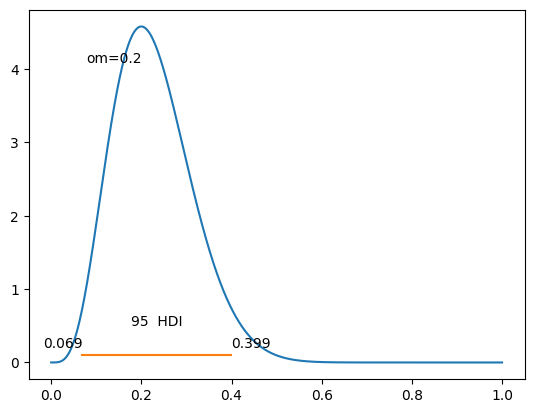

In [8]:
plot_beta(a=alph+head, b=bet+trials-head)